In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## TODO:

1. Data: 
    - **done** create script to combine all congresses
    - **done** create a party and chamber lists for addtional support
    - **done** create congress number list

2. Train/Val/Test split:
    - Put into a separate module
    - Add an option to select a party or chapter
    - Split train/val/test by congress to avoid time bias
    - Play with hyperparameters:
        - word_count
        - random_splits: allocate more to training?
        - increase balance ratio?

3. EDA:
    - Targets by party: should we run gender/ethnicity on Ds only?

4. Vectorization:
    - Tune hyper parameters:
        - ngram_range: 1, 3
        - change vocabulary size
    - Add outputs:
        - stop words
        - lowest scoring words
        - top 5/bottom 5 by congress

5. Ngram model:
    - Tune hyper parameters:
        - use GridSearch?
        - activation function
        - learning rate
        - batch size
        - layers
        - units
        - dropout rate
        - any other regularization (there is significant overfit)
    - Run model:
        - for each congress
        - add one congress at a time
           - hypothesis: is accuracy improving due to more data or more diversity?
        - run only for Ds?
    - Outputs:
        - how to output predicted probablity?
    - Model validation:
        - build a separate function so it can be used with different models:
            - input: predicted probability; actual labels; data (val or test?)
        - chart distribution of the predicted probability 
        - bin predicted probabilities into:
            - 0:0.4, 0.4:0.6, 0.6:1?
            - accuracy in each bin
            - crosstab them with various demos (party, chamber, age, year)
            - get 1,2,3-grams for each bin
        - output examples of speeches with scores close to 1 and close to 0 that are mispredicted vs predicted correctly
        - Accuracy/loss by congress
        - Accuracy/loss as congresses added
            - save them and plot them

### Long term:

1. classificaiton models:
    - ngram vanilla NN
    - CNN
    - some other models
    - does it help to combine the results ensemble? if they make different mistakes, it should.
2. Create a topics model:
    - on raw data before classification
    - on groups based on predicted probability bings:
       - can we explain classification by topics that they bring up?
       - or is it just based on language used? here we would check 1,2,3-ngrams
3. Age:
    - aging congress: how does it affect topics that people bring up?
4. Speaker-level analysis:
    - cluster speakers (k-means?) by their average predicted scores in classification models?
        - for example, a white male that is closer to women by the way they use speech? are they liberals?

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np
import pandas as pd

from importlib import reload

import nltk, re, pprint
from nltk import word_tokenize

In [5]:
from w266_common import utils, vocabulary
from helpers import load_data
from helpers import explore_data

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [ ]:
filepath = '/tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt'
with open(filepath, 'rb') as f:
    raw = f.read().decode(errors='replace')

In [8]:
type(raw), len(raw)

(str, 249718612)

In [9]:
raw.find('\n')

16

In [10]:
raw[:16]

'speech_id|speech'

In [11]:
raw = raw.split('\n')[1:]

In [12]:
len(raw)

283399

In [13]:
raw[:2]

['970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for this body we pray

In [14]:
speech_ids, speeches = [], []
for speech in raw:
    speech = speech.split('|')
    # skipping empty rows
    if speech:
        speech_ids.append(speech[0])
        # some speeches have pipes in them
        speeches.append(' '.join(speech[1:]))

In [15]:
len(speech_ids), len(speeches)

(283399, 283399)

In [16]:
speech_ids[0]

'970000001'

## Create target labels

In [17]:
ls /tf/notebooks/final-project/data/QA

README.md                ethicity_aapia.txt        gs_connect.py@
__pycache__/             ethicity_black.txt        hein_daily_qa.sh*
cnt_speaker_id.sh*       ethicity_hispanic.txt     hein_daily_qa.txt
cnt_speaker_id.txt       full_descr.txt            nltk.ipynb
collecting_demo.ipynb    full_descr.zip            speakermap_qa.ipynb
congresspeople_age.txt   full_speakermap.py*       speakermap_qa.py*
congresspeople_demo.txt  full_speakermap.txt       speakermap_qa.txt
congresspeople_id.txt    full_speakermap_demo.txt  speech_descr_qa.ipynb


In [18]:
descr = {}
with open('/tf/notebooks/final-project/data/QA/full_descr.txt') as f:
    for line in f:
        line = line.strip().split('|')
        if line[0] == 'speech_id':
            keys = line[1:]
        else:
            descr[line[0]] = {k:v for k,v in zip(keys, line[1:])}

In [19]:
descr['970000005']

{'Age': '63.0',
 'Age_lt_med': '0.0',
 'Chamber': 'S',
 'Congress': '97',
 'Ethnicity': 'W',
 'Female': '0.0',
 'Full Name': 'PERCY, CHARLES',
 'NonWhite': '0.0',
 'Party': 'R',
 'State': 'IL',
 'char_count': '201',
 'date': '19810105',
 'match': 'exact',
 'speaker': 'Mr. PERCY',
 'speakerid': '97105301.0',
 'word_count': '34'}

In [20]:
descr97 = []
for s in descr:
    if s[:2] == '97':
        descr97.append(s)
len(descr97)

220819

In [21]:
descr97.sort()

In [22]:
descr97[0], descr97[-1]

('970000005', '970283398')

In [23]:
# percent of speeches that matched speaker ids
len(descr97)/len(speech_ids)

0.7791805899103385

In [24]:
gender, ethnicity, age = [], [], []
for i in speech_ids:
    gender.append(int(float(descr.get(i, {}).get('Female', '-1'))))
    ethnicity.append(int(float(descr.get(i, {}).get('NonWhite', '-1'))))
    age.append(int(float(descr.get(i, {}).get('Age_lt_med', '-1'))))

In [25]:
len(gender), len(ethnicity), len(age)

(283399, 283399, 283399)

In [26]:
def get_counts(lst):
    """
    Checks the distribution of target variables
    """
    unique, counts = np.unique(lst[0], return_counts=True)
    M = np.concatenate((unique.astype(int), counts.astype(int))).reshape((2,3)).T
    print(lst[1])
    utils.pretty_print_matrix(M, cols=['Category', 'Count'], dtype=int)

for i in [(gender, "gender"), (ethnicity, "ethnicity"), (age, "age")]:
    get_counts(i)

gender


,Category,Count
0,-1,62580
1,0,216368
2,1,4451


ethnicity


,Category,Count
0,-1,62580
1,0,211468
2,1,9351


age


,Category,Count
0,-1,62580
1,0,143811
2,1,77008


### Data QA

In [27]:
def random_speech(data, ids, target, value):
    """
    Prints a random speech for a specific target value
    
    Args:
        data: list of speeches
        ids: list of speech ids
        target: list of 0,1 
        value: int, 0 or 1
    """
    r = np.random.choice(np.array(ids)[np.array(target)==value])
    print("Speaker information")
    for i in descr[r]:
        print(i, descr[r][i])
    print()
    print(data[ids.index(r)])

In [28]:
random_speech(speeches, speech_ids, gender, 1)

Speaker information
Ethnicity W
char_count 495
Chamber H
word_count 82
State NY
Age_lt_med 1.0
Age 47.0
NonWhite 0.0
Congress 97
speakerid 97106680.0
match exact
speaker Ms. FERRARO
Full Name FERRARO, GERALDINE
Female 1.0
date 19820615
Party D

Mr. Chairman. I thank the gentleman for yielding. If the New York City Police were taken off the extraordinary protection and Treasury were required to provide the protective services for diplomats as they are required by treaties to do. it would cost the Federal Government $20 million in the first year and $14 million for each additional year thereafter. and in addition to that. they still would not be providing all the extraordinary protection the New York City Police have been providing.


In [29]:
random_speech(speeches, speech_ids, ethnicity, 1)

Speaker information
Ethnicity H
char_count 2539
Chamber H
word_count 442
State CA
Age_lt_med 0.0
Age 66.0
NonWhite 1.0
Congress 97
speakerid 97109720.0
match exact
speaker Mr. ROYBAL
Full Name ROYBAL, EDWARD
Female 0.0
date 19821218
Party D

Mr. Chairman. I move to strike the requisite number of words. Mr. Chairman. I think that one can say at this point that we can agree with all the previous speakers because each one of them have made excellent points. but I would like to get back to the amendment now before the House. I would like to try to get some understanding of the opposition that has arisen on the part of the gentleman from Texas and the gentleman from Texas . Before I do that. I would like to set the stage for the questions that will follow. On page 4. line 19 of the bill. it states as follows: The person or entityThis means the employermust attest. under penalty of perjury and on a form designated or established by the Attorney General by regulation. that It has verified tha

In [30]:
random_speech(speeches, speech_ids, age, 1)

Speaker information
Ethnicity W
char_count 2514
Chamber S
word_count 452
State MI
Age_lt_med 1.0
Age 48.0
NonWhite 0.0
Congress 97
speakerid 97117441.0
match exact
speaker Mr. LEVIN
Full Name LEVIN, CARL
Female 0.0
date 19820805
Party D

Mr. President. I thank my friend from Ohio. First -of all. I thank him and all those who worked so hard on this resolution. The matter of supplemental benefits is a matter of national policy. We have for 30 consecutive months worked with doubledigit unemployment. Since January 40.000 people in Michigan have exhausted their extended benefits. We justAimply need desperately this supplemental unemployment benefit. I hope this is the second from the last step on this road. It is obviously not the last step. but we need that final step. The Senator from Kansas has put his finger on it. That last step. if it is going to be made. is going to have to be made in conference. and we look forward to his leadership in that regard. Just to give you some Idea of the 

## Split into train, validate, test

In [1]:
def filter_data(data, ids, target, filter, value):
    data_f, ids_f, target_f = [], [], []
    for i in range(len(target)):
        if filter[i] == value:
            data_f.append(data[i])
            ids_f.append(ids[i])
            target_f.append(target[i])

    return data_f, ids_f, target_f

In [31]:
def split_train_val_test(data, ids, target, balance, splits, word_count=30):
    """
    Splits speeches into train, validation and test samples
    
    Args:
        data: list of speeches
        ids: list of speech ids
        target: list of target values (0,1,-1)
        balance: desired ratio of 0s to 1s
        splits: list of floats for [train, validation, test] splits
    
    Kwards:
        word_count: min number of words in the speech
    
    Returns:
        tuple of lists: train speeches, speech ids and target, 
                        validation speeches, speech ids and target, 
                        test speeches, speech ids and target
    """
    
    # initialize lists to hold speeches
    ones, zeroes = [], []
    ones_ids, zeroes_ids = [], []
    
    for i in range(len(target)):
        # -1 indicated non-matched speeches. They are dropped
        # select only speeches that have at least min
        # desired length
        if (target[i] != -1) and (int(descr[ids[i]]['word_count']) > word_count):
            if target[i] == 1:
                ones.append(data[i])
                ones_ids.append(ids[i])
            elif target[i] == 0:
                zeroes.append(data[i])
                zeroes_ids.append(data[i])
    
    # get lengths of train, validation and test lists
    train_ones_len = int(len(ones)*splits[0])
    val_ones_len = int(len(ones)*splits[1])
    test_ones_len = len(ones) - train_ones_len - val_ones_len
    
    if int(len(ones)*balance) < len(zeroes):
        train_zeroes_len = int(train_ones_len*balance)
        val_zeroes_len = int(val_ones_len*balance)
        test_zeroes_len = int(test_ones_len*balance)
    else:
        train_zeroes_len = int(len(zeroes)*splits[0])
        val_zeroes_len = int(len(zeroes)*splits[1])
        test_zeroes_len = len(zeroes) - train_zeroes_len - test_zeroes_len
    
    # create randomly shuffled indices
    random.seed(100)    
    ones_shuffled = np.random.permutation(np.arange(len(ones)))
    zeroes_shuffled = np.random.permutation(np.arange(len(zeroes)))
    
    # subset lists of speeches based on shuffled indices
    train_ones = [ones[i] for i in ones_shuffled[:train_ones_len]]
    val_ones = [ones[i] for i in ones_shuffled[train_ones_len:-test_ones_len]]
    test_ones = [ones[i] for i in ones_shuffled[-test_ones_len:]]

    train_ones_ids = [ones_ids[i] for i in ones_shuffled[:train_ones_len]]
    val_ones_ids = [ones_ids[i] for i in ones_shuffled[train_ones_len:-test_ones_len]]
    test_ones_ids = [ones_ids[i] for i in ones_shuffled[-test_ones_len:]]

    train_zeroes = [zeroes[i] for i in zeroes_shuffled[:train_zeroes_len]]
    val_zeroes = [zeroes[i] for i in zeroes_shuffled[train_zeroes_len:train_zeroes_len+val_zeroes_len]]
    test_zeroes = [zeroes[i] for i in zeroes_shuffled[-test_zeroes_len:]]

    train_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[:train_zeroes_len]]
    val_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[train_zeroes_len:train_zeroes_len+val_zeroes_len]]
    test_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[-test_zeroes_len:]]

    # combine lists
    train = train_ones + train_zeroes
    val = val_ones + val_zeroes
    test = test_ones + test_zeroes

    train_ids = train_ones_ids + train_zeroes_ids
    val_ids = val_ones_ids + val_zeroes_ids
    test_ids = test_ones_ids + test_zeroes_ids

    # create target lists
    train_target = [1]*len(train_ones) + [0]*len(train_zeroes)
    val_target = [1]*len(val_ones) + [0]*len(val_zeroes)
    test_target = [1]*len(test_ones) + [0]*len(test_zeroes)

    print("Training split: {} ones and {} zeroes".format(train_ones_len, train_zeroes_len))
    print("Training speech list size: {}".format(len(train)))
    print("Training target list size: {}".format(len(train_target)))

    print("Validation split: {} ones and {} zeroes".format(val_ones_len, val_zeroes_len))
    print("Validation speech list size: {}".format(len(val)))
    print("Validation target list size: {}".format(len(val_target)))    
    
    print("Test split: {} ones and {} zeroes".format(test_ones_len, test_zeroes_len))
    print("Test speech list size: {}".format(len(test)))
    print("Test target list size: {}".format(len(test_target)))

    return train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target

In [32]:
random_splits = [0.6, 0.2, 0.2]
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = split_train_val_test(speeches, speech_ids, gender, 1, random_splits)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [33]:
sum(train_target), sum(val_target), sum(test_target)

(1622, 540, 542)

In [34]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

1747

In [35]:
random_speech(train, train_ids, train_target, 1)

Speaker information
Ethnicity W
char_count 1029
Chamber H
word_count 188
State CO
Age_lt_med 1.0
Age 42.0
NonWhite 0.0
Congress 97
speakerid 97111540.0
match exact
speaker Mrs. SCHROEDER
Full Name SCHROEDER, PATRICIA
Female 1.0
date 19810730
Party D

Mr. Chairman. I offer an amendment to prohibit any part of an appropriation for the President and the Executive Office from going for gifts to Members of Congress for the purpose of Influencing their votes on legislation. Today may be the most important day to discuss this issue. Earlier this year. when the budget was under discussion. the President Invited wavering Members down to the White House. gave them a pair of cuff links. and they came back to the Hill wavering no more. Just last weekend. the President upped the ante on the tax bill by taking a group of Members in a spiffy Army helicopter to Camp David for hot dogs and hamburgers. A month ago. the President tried to buy Memberss votes for cuff links. a few days ago. he moved to hot

In [36]:
random_speech(val, val_ids, val_target, 1)

Speaker information
Ethnicity W
char_count 1522
Chamber H
word_count 267
State LA
Age_lt_med 0.0
Age 66.0
NonWhite 0.0
Congress 97
speakerid 97108080.0
match exact
speaker Mrs. BOGGS
Full Name BOGGS, CORINNE
Female 1.0
date 19810915
Party D

Mr. Speaker. it Is with deep sympathy that I mourn. the death of Catherine Norrell. I am among those who had the good fortune to enjoy her friendship as well as that of her husband. the late William Norrell. Both were Members of this House. and both did a superb job of service to the people of Arkansas and the people of the United States. I greatly admired Catherines own spirit of enthusiasm and her unending support of Bill during his 22 years in office. She was behind him all the way. with an ear to listen and a hand to help. So strong was her desire to see the people of Arkansas grow and prosper and so deep was her conviction in Bills plans to make this happen that upon Bills death she ran In a hotly contested race to represent the Sixth District

In [37]:
random_speech(test, test_ids, test_target, 1)

Speaker information
Ethnicity W
char_count 2054
Chamber H
word_count 323
State NY
Age_lt_med 1.0
Age 47.0
NonWhite 0.0
Congress 97
speakerid 97106680.0
match fuzzy
speaker Ms. FERRARO
Full Name FERRARO, GERALDINE
Female 1.0
date 19810518
Party D

Mr. Speaker. I would like to take this opportunity to offer my congratulations on the 50th anniversary of Grover Cleveland High School. Education is the foundation upon which a society is built. Quality education is the foundation upon which a great society is built. For half a century Grover Cleveland High School has been educating the young people of the Ridgewood community. Grover Cleveland offers students the opportunity to excel in the academic. vocational. and athletic areas. Grover Cleveland High School opened in September 1931. under the leadership of Dr. Charles A. Tonsor. Dr. Tonsor maintained extensive ties with the community during his entire tenure. In June 1955. Dr. Tonsor retired and was followed by Mr. Edward Kramer. Mr. Kramer

## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [38]:
reload(explore_data)

<module 'helpers.explore_data' from '/tf/notebooks/final-project/Classification/helpers/explore_data.py'>

In [39]:
explore_data.get_num_words_per_sample(train)

210.0

In [40]:
explore_data.get_num_words_per_sample(val)

196.5

In [41]:
explore_data.get_num_words_per_sample(test)

207.0

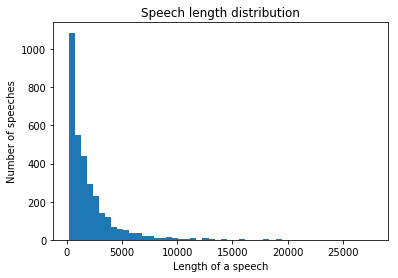

In [42]:
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'we', 'it', 'on', 'have', 'be', 'are', 'as', 'not', 'by', 'with', 'will', 'our', 'mr', 'has', 'from', 'would', 'was', 'an', 'which', 'my', 'at', 'they', 'their', 'or', 'who', 'but', 'all', 'been', 'president', 'he', 'bill', 'these', 'his', 'if', 'do', 'people', 'there', 'more', 'can', 'amendment', 'one']


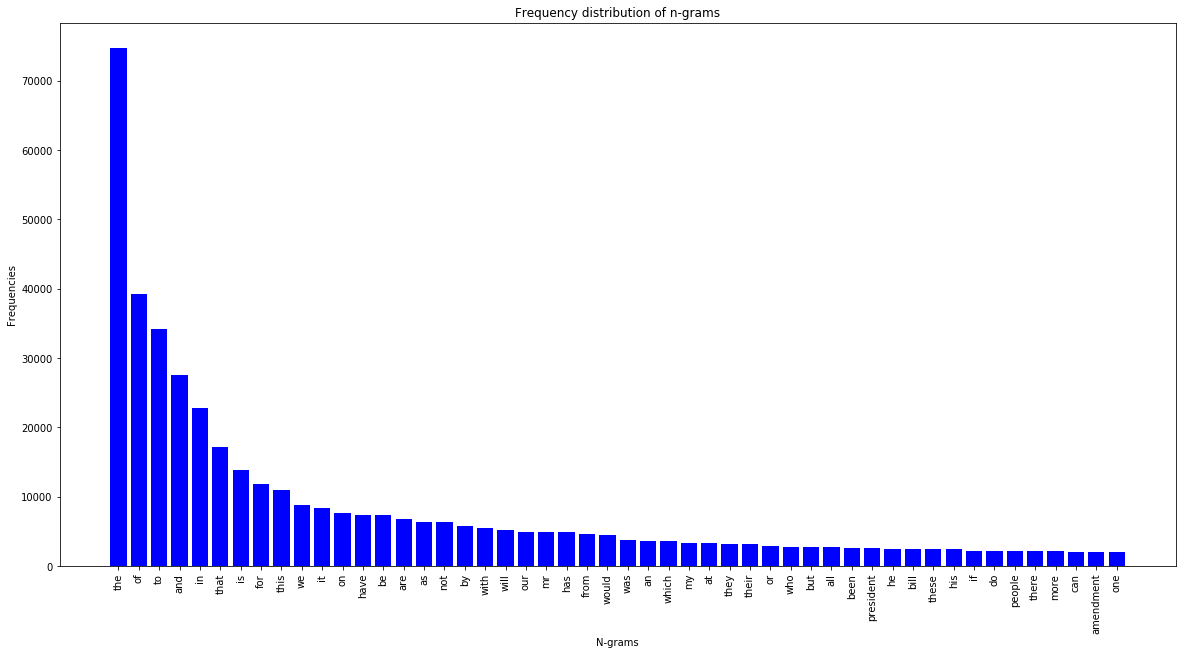

In [43]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'that the', 'for the', 'and the', 'on the', 'by the', 'mr speaker', 'of this', 'to be', 'with the', 'we are', 'we have', 'mr president', 'that we', 'will be', 'has been', 'of our', 'the gentleman', 'in this', 'from the', 'the united', 'is the', 'united states', 'would be', 'that is', 'at the', 'have been', 'the house', 'do not', 'mr chairman', 'is not', 'my colleagues', 'there is', 'the federal', 'the senate', 'the committee', 'as the', 'this is', 'this bill', 'like to', 'want to', 'the bill', 'one of', 'the president', 'would like', 'going to', 'they are']


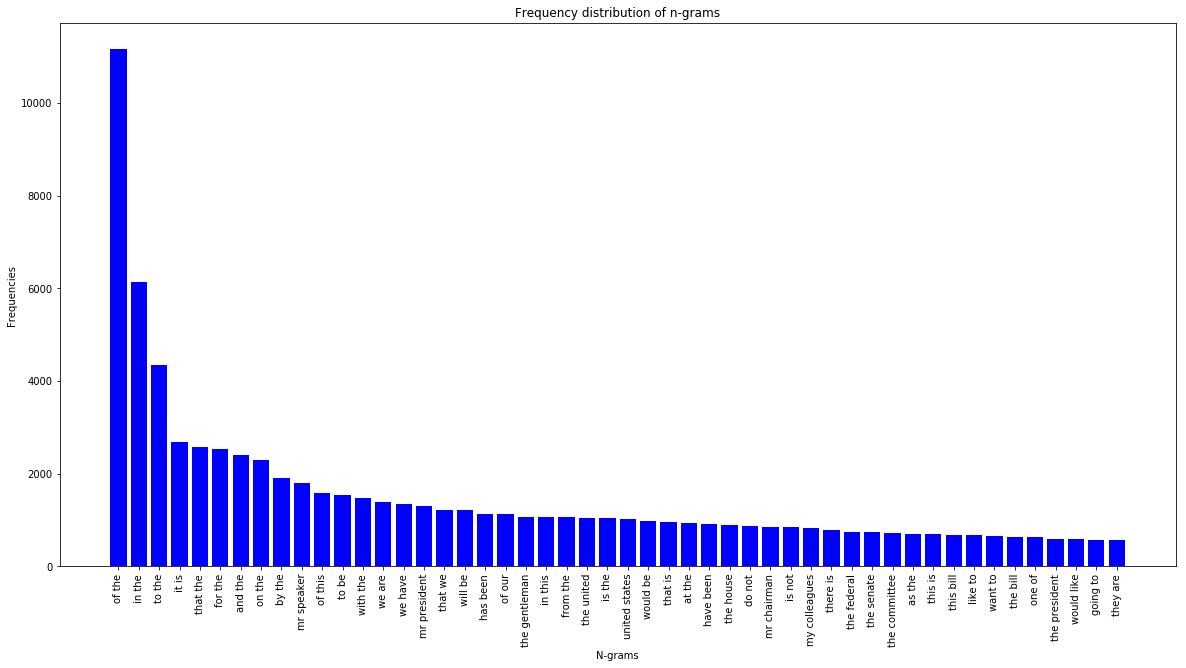

In [44]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'would like to', 'the gentleman from', 'the senator from', 'one of the', 'the soviet union', 'the federal government', 'chairman of the', 'the department of', 'of the united', 'percent of the', 'my colleagues to', 'as well as', 'of the house', 'in support of', 'there is no', 'the people of', 'are going to', 'the american people', 'in order to', 'the fact that', 'member of the', 'thank the gentleman', 'some of the', 'members of the', 'urge my colleagues', 'in the record', 'part of the', 'ask unanimous consent', 'the committee on', 'in the united', 'that we are', 'we do not', 'it is not', 'in this country', 'support of the', 'be able to', 'that we have', 'mr speaker the', 'of the committee', 'mr chairman rise', 'of the senate', 'because of the', 'the gentleman for', 'of my colleagues', 'unanimous consent that', 'think it is', 'of the bill', 'rise in support', 'that it is']


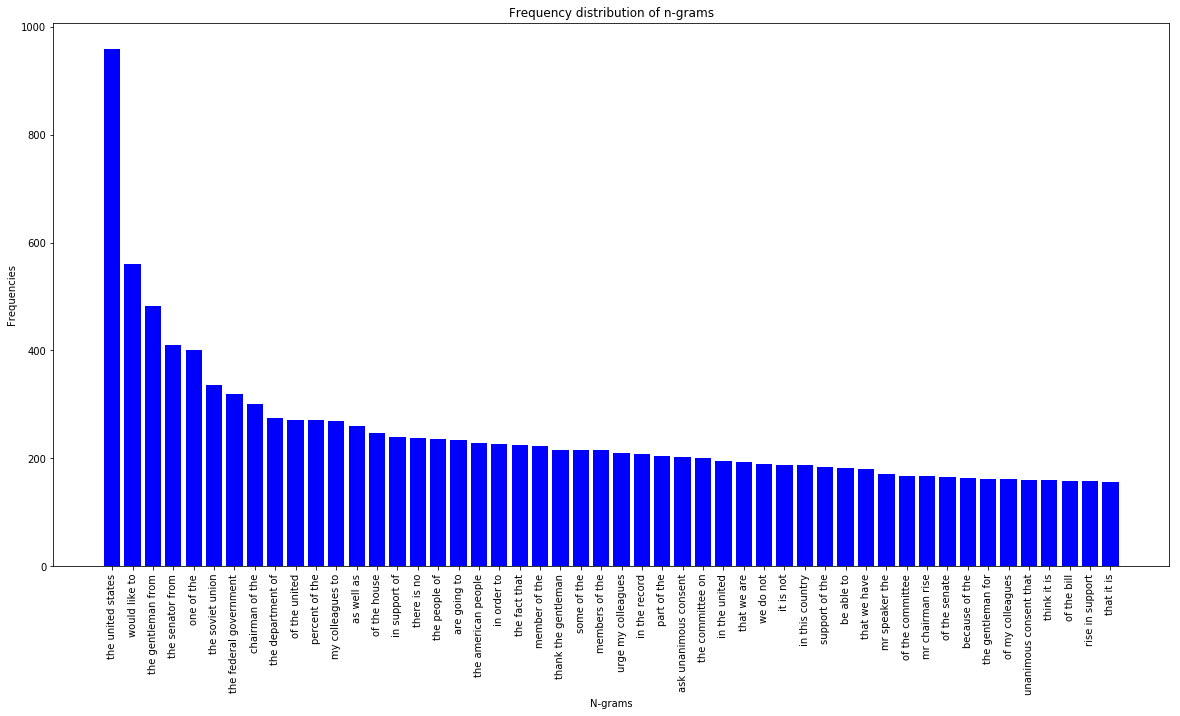

In [45]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(3,3))

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [47]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [48]:
import tensorflow as tf

### Pre-processing

In [49]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

In [50]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of ngrams.

    Arguments:
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    Returns:
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'max_df': MAX_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)
    print("Total vocabulary size: {}".format(len(vectorizer.vocabulary_)))
    
    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype(dtype=np.float32)
    x_val = selector.transform(x_val).astype(dtype=np.float32)
    
    top_words = np.array(vectorizer.get_feature_names())[np.argsort(selector.scores_)[::-1]][:20]
    top_scores = selector.scores_[np.argsort(selector.scores_)[::-1]][:20]
    print("\nTop 20 words by differentiating score:")
    for i in range(len(top_words)):
        print(top_words[i], "\t", round(top_scores[i], 1))
    
    return x_train, x_val

In [51]:
train_vec, val_vec = ngram_vectorize(train, train_target, val)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Total vocabulary size: 34739

Top 20 words by differentiating score:
mr president 	 311.6
senator 	 169.2
president 	 168.9
the senator 	 133.4
senator from 	 115.9
women 	 83.5
the senate 	 76.6
consent 	 74.3
senate 	 70.6
distinguished 	 68.3
unanimous consent 	 67.7
ask unanimous 	 65.6
senators 	 64.7
the distinguished 	 64.4
unanimous 	 62.2
people 	 54.6
consent that 	 54.6
speaker 	 49.1
mr speaker 	 45.3
are 	 43.9


In [52]:
len(train), len(val)

(3244, 1080)

In [53]:
train_vec.shape, val_vec.shape

((3244, 20000), (1080, 20000))

### Model: Multi-Layer Perceptron (Vanilla NN)

In [54]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    Returns
        An MLP model instance.
    """
    op_units, op_activation = 1, 'sigmoid'
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    
    return model

In [55]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """
    Trains n-gram model on the given dataset.

    Arguments:
        data: tuples of vectorized training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    Returns:
        tuple with accuracy and loss on validation data for the last interation
    """
    # Get the data.
    (x_train, train_labels), (x_val, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
#     model.save('C97_mlp_model.h5')
    
    return history['val_acc'][-1], history['val_loss'][-1]

In [56]:
train_ngram_model(((train_vec, train_target), (val_vec, val_target)))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 3244 samples, validate on 1080 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 1s - loss: 0.6754 - acc: 0.6751 - val_loss: 0.6564 - val_acc: 0.6963
Epoch 2/1000
 - 1s - loss: 0.5903 - acc: 0.8428 - val_loss: 0.6112 - val_acc: 0.7250
Epoch 3/1000
 - 1s - loss: 0.4944 - acc: 0.8927 - val_loss: 0.5743 - val_acc: 0.7315
Epoch 4/1000
 - 1s - loss: 0.4054 - acc: 0.9195 - val_loss: 0.5478 - val_acc: 0.7361
Epoch 5/1000
 - 1s - loss: 0.3297 - acc: 0.9387 - val_loss: 0.5339 - val_acc: 0.7370
Epoch 6/1000
 - 1s - loss: 0.2704 - acc: 0.9572 - val_loss: 0.5262 - val_acc: 0.7398
Epoch 7/1000
 - 1s - loss: 0.2211 - acc: 0.9676 - val_loss: 0.5230 - val_acc: 0.7343
Epoch 8/1000
 - 1s - loss: 0.1803 - acc: 0.9812 - val_loss: 0.5244 - val_acc: 0.7315
Epoch 9/1000
 - 1s - loss: 0.1507 - a

(0.7287037, 0.5277308088761788)